In [30]:
# Libraries
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import gc
import torchsummary
from datetime import datetime
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score

In [2]:
#torch seed and device info
torch.random.manual_seed(0)
!nvidia-smi

Sat Nov 29 16:46:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500               Off |   00000000:01:00.0 Off |                  Off |
| 30%   30C    P8             22W /  230W |      15MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A5500 (UUID: GPU-8dd8bd39-a66b-8aa3-ce58-81c5e214a054)
GPU 1: NVIDIA RTX A5500 (UUID: GPU-0d143765-9b0e-0a6a-0f03-2a9a43a39889)
GPU 2: NVIDIA RTX A5500 (UUID: GPU-cd01c66c-b823-0ed5-f79c-20e623459232)


In [494]:
# Paths and data split
imagesWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Tiles"
masksWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Masks"
imagesDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Tiles"
masksDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Masks"
BaseWeightWetPath = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS/weightsWetSeason.pth"
BaseWeightDryPath = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/CataloniaDS/WeightsCatalonia/weightsDrySeason.pth"
weightsWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Weights"
weightsDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights"
predictionsWetSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Predictions"
predictionsDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Predictions"

# Train and test - Wet Season

 Base model is used here

In [495]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [496]:
imageWet = sorted(glob.glob(imagesWetSeason + "/*.tif"))
maskWet = sorted(glob.glob(masksWetSeason + "/*.png"))
trainTilesWet, testTilesWet, trainWetMasks, testWetMasks = train_test_split(
    imageWet, maskWet, test_size=0.3, random_state=42
)

trainWetDS = FourBandSegmentationDataset(imagesWetSeason, masksWetSeason, files_list=(trainTilesWet, trainWetMasks))
testWetDS = FourBandSegmentationDataset(imagesWetSeason, masksWetSeason, files_list=(testTilesWet, testWetMasks))

In [497]:
batch_size = 4
trainloaderWet = DataLoader(trainWetDS, batch_size=batch_size, shuffle=True)
testloaderWet = DataLoader(testWetDS, batch_size=batch_size, shuffle=True)

In [498]:
len(trainWetDS),len(testWetDS)

(387, 167)

## Model for NN:

In [499]:
inputBands = 4
outputBands=1

In [500]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

In [478]:
class UNet(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [479]:
class UNetFreeze(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands, freeze_encoder=False):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024, dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512, dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256, dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128, dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64, dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)

        # Congelar capas del encoder si freeze_encoder=True
        if freeze_encoder:
            for param in self.enc1.parameters():
                param.requires_grad = False
            for param in self.enc2.parameters():
                param.requires_grad = False
            for param in self.enc3.parameters():
                param.requires_grad = False
            for param in self.enc4.parameters():
                param.requires_grad = False

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        return self.conv_last(dec1)

In [482]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [481]:
print(torch.cuda.is_available())
device = torch.device(1 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:1


In [483]:
#Losses:

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss
    
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

In [484]:
model = UNet(in_channels=inputBands, out_channels=outputBands).to(device)
criterion = TverskyLoss(alpha=0.7, beta=0.3)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 20

In [ ]:
#model with option to freeze encoder for transfer learning
model = UNetFreeze(in_channels=inputBands, out_channels=outputBands, freeze_encoder=True).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)
# Solo optimizar las capas no congeladas
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
epochs = 20

In [485]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [486]:
# load weights in model
model.load_state_dict(torch.load(BaseWeightWetPath, map_location=device))

<All keys matched successfully>

## Model evaluation - Pre-training

In [19]:
# Eval model before training - test generalization
model.eval()

UNetFreeze(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Seque

In [20]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics
    return {k: np.mean(v) for k, v in results.items()}

In [21]:
predict_th = 0.5

In [22]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in trainloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [23]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.3843
Dice: 0.5163
Precision: 0.4683
Recall: 0.7308


In [24]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [25]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.3866
Dice: 0.5444
Precision: 0.4518
Recall: 0.7254


## Finding LR

In [77]:
def lrFinder(model, optimizer_class, criterion, dataloader, device, 
                     start_lr=1e-7, end_lr=1, num_iter=100):
    model.train()
    lrs = []
    losses = []

    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr

    optimizer = optimizer_class(model.parameters(), lr=lr)
    iter_count = 0

    for inputs, targets in dataloader:
        if iter_count > num_iter:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(lr)
        losses.append(loss.item())

        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        iter_count += 1

    return lrs, losses

Device: cuda:2


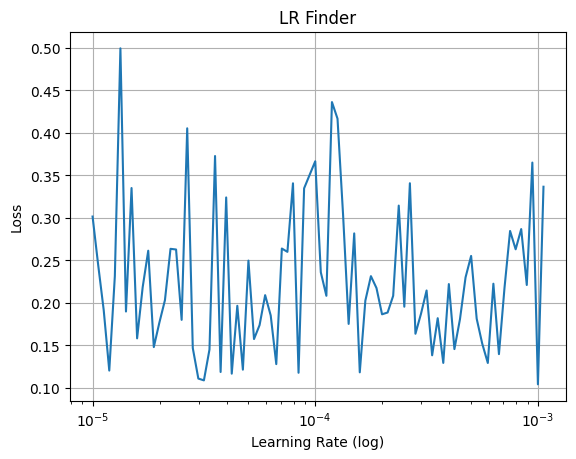

In [ ]:
print(f"Device: {device}")
lrs, losses = lrFinder(model, torch.optim.AdamW, TverskyLoss(), trainloaderWet, device,start_lr=1e-5,num_iter=200)

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (log)")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.grid()
plt.show()

## Training new model with data

In [503]:
# load weights of base model in model to train
model.load_state_dict(torch.load(BaseWeightWetPath, map_location=device))

<All keys matched successfully>

In [502]:
# Test if with no weights, a better model can be achieved
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            reset_weights(layer)  # aplica recursivamente

reset_weights(model)

In [487]:
model.train()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [489]:
#Train loop:
def get_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def get_jaccard(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

def train_model(model, loss_function, optimizer, epochs, train_loader, test_loader, device,patience=5, save_path=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        #train_acc = 0.0
        train_jaccard = 0.0
        n_train = 0

        for imgs, masks in train_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            batch_size = imgs.size(0)
            train_loss += loss.item() * batch_size
            #train_acc += get_accuracy(outputs, masks) * batch_size
            train_jaccard += get_jaccard(outputs, masks) * batch_size
            n_train += batch_size

        train_loss /= n_train
        #train_acc /= n_train
        train_jaccard /= n_train
        train_losses.append(train_loss)
        #train_accuracies.append(train_acc.cpu().item())
        train_accuracies.append(train_jaccard.cpu().item())

        model.eval()
        test_loss = 0.0
        #test_acc = 0.0
        test_jaccard = 0.0
        n_test = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device).float()
                masks = masks.to(device).float()
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                batch_size = imgs.size(0)
                test_loss += loss.item() * batch_size
                #test_acc += get_accuracy(outputs, masks) * batch_size
                test_jaccard += get_jaccard(outputs, masks) * batch_size
                n_test += batch_size

        test_loss /= n_test
        #test_acc /= n_test
        test_jaccard /= n_test
        test_losses.append(test_loss)
        #test_accuracies.append(test_acc.cpu().item())
        test_accuracies.append(test_jaccard.cpu().item())

        #print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - jacc: {train_jaccard:.4f} - val_loss: {test_loss:.4f} - val_jacc: {test_jaccard:.4f}")

        if save_path is not None:
            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [504]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestModel = os.path.join(weightsWetSeason, f"weights_{timestamp}.pth")
os.makedirs(os.path.dirname(bestModel), exist_ok=True)

In [505]:
bestModel

'/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Weights/weights_20251129_204214.pth'

In [506]:
print(device)

cuda:1


In [507]:
# Entrenamiento
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.7, beta=0.3)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 70
pat = 30

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, criterion, optimizer, epochs, trainloaderWet, testloaderWet, device=device,patience = pat,save_path=bestModel
)

Epoch 1/70 - loss: 0.3423 - jacc: 0.4977 - val_loss: 0.3324 - val_jacc: 0.5144
Epoch 2/70 - loss: 0.3134 - jacc: 0.5290 - val_loss: 0.3128 - val_jacc: 0.5269
Epoch 3/70 - loss: 0.3202 - jacc: 0.5171 - val_loss: 0.3137 - val_jacc: 0.5069
Epoch 4/70 - loss: 0.2976 - jacc: 0.5468 - val_loss: 0.3041 - val_jacc: 0.5695
Epoch 5/70 - loss: 0.2872 - jacc: 0.5526 - val_loss: 0.2932 - val_jacc: 0.5452
Epoch 6/70 - loss: 0.3042 - jacc: 0.5427 - val_loss: 0.4180 - val_jacc: 0.4713
Epoch 7/70 - loss: 0.3215 - jacc: 0.5149 - val_loss: 0.3358 - val_jacc: 0.4488
Epoch 8/70 - loss: 0.2901 - jacc: 0.5501 - val_loss: 0.2975 - val_jacc: 0.5111
Epoch 9/70 - loss: 0.2776 - jacc: 0.5634 - val_loss: 0.3337 - val_jacc: 0.4352
Epoch 10/70 - loss: 0.2765 - jacc: 0.5653 - val_loss: 0.2953 - val_jacc: 0.5013
Epoch 11/70 - loss: 0.2792 - jacc: 0.5602 - val_loss: 0.2780 - val_jacc: 0.5554
Epoch 12/70 - loss: 0.2697 - jacc: 0.5778 - val_loss: 0.2726 - val_jacc: 0.5652
Epoch 13/70 - loss: 0.2596 - jacc: 0.5818 - val_l

In [57]:
# Entrenamiento Con Transfer Learning - codifier congelado
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
epochs = 50
pat = 10

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, criterion, optimizer, epochs, trainloaderWet, testloaderWet, device=device,patience = pat,save_path=bestModel
)

Epoch 1/50 - loss: 0.3917 - jacc: 0.4457 - val_loss: 0.3920 - val_jacc: 0.4460
Epoch 2/50 - loss: 0.3653 - jacc: 0.4736 - val_loss: 0.3917 - val_jacc: 0.4468
Epoch 3/50 - loss: 0.3545 - jacc: 0.4834 - val_loss: 0.3719 - val_jacc: 0.4647
Epoch 4/50 - loss: 0.3538 - jacc: 0.4868 - val_loss: 0.3756 - val_jacc: 0.4638
Epoch 5/50 - loss: 0.3448 - jacc: 0.4949 - val_loss: 0.3659 - val_jacc: 0.4758
Epoch 6/50 - loss: 0.3387 - jacc: 0.5010 - val_loss: 0.3644 - val_jacc: 0.4741
Epoch 7/50 - loss: 0.3353 - jacc: 0.5055 - val_loss: 0.3632 - val_jacc: 0.4783
Epoch 8/50 - loss: 0.3308 - jacc: 0.5092 - val_loss: 0.3556 - val_jacc: 0.4837
Epoch 9/50 - loss: 0.3355 - jacc: 0.5066 - val_loss: 0.3571 - val_jacc: 0.4839
Epoch 10/50 - loss: 0.3308 - jacc: 0.5128 - val_loss: 0.3714 - val_jacc: 0.4721
Epoch 11/50 - loss: 0.3318 - jacc: 0.5118 - val_loss: 0.3522 - val_jacc: 0.4868
Epoch 12/50 - loss: 0.3279 - jacc: 0.5158 - val_loss: 0.3534 - val_jacc: 0.4893
Epoch 13/50 - loss: 0.3203 - jacc: 0.5235 - val_l

In [508]:
def show_results(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label='train')
    ax1.plot(test_losses, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(test_accuracies, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

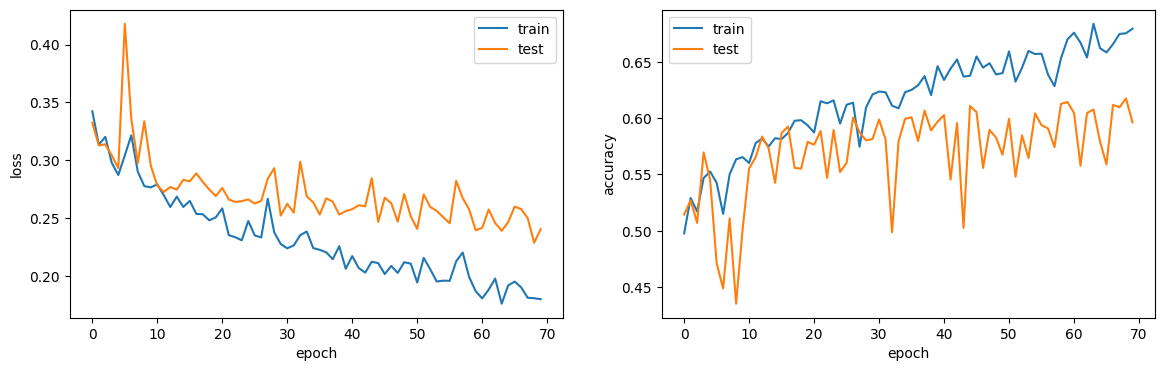

In [509]:
# Visualize
show_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [562]:
predict_th = 0.9

In [511]:
modelToEvalPath = bestModel
model.load_state_dict(torch.load(modelToEvalPath, map_location=device))

<All keys matched successfully>

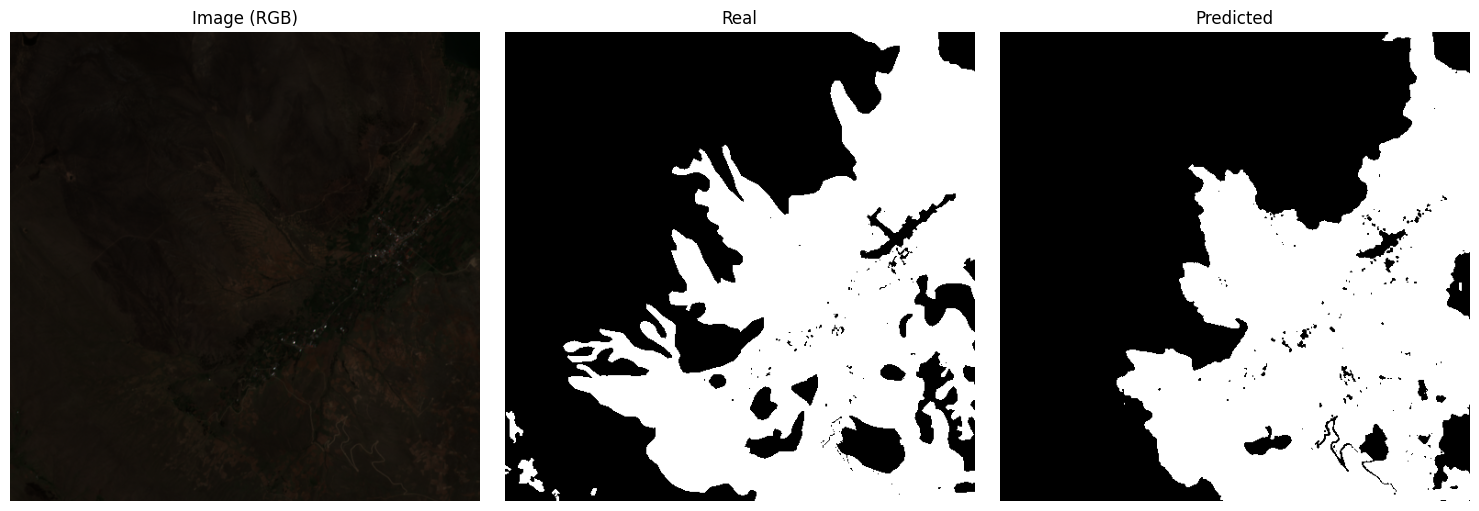

In [579]:
# Eval and visualize
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(testloaderWet))
    imgs = imgs.to(device)
    outputs = model(imgs)
    pred_mask = (outputs[0] > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Evaluation post - training

In [160]:
#modelToEvalPath = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Weights/AndeanCropModelModifiedWet.pth"
modelToEvalPath = bestModel
model.load_state_dict(torch.load(modelToEvalPath, map_location=device))

<All keys matched successfully>

In [136]:
device

device(type='cuda', index=1)

In [541]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics

In [580]:
predict_th = 0.9

In [581]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [582]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.6102
Dice: 0.7516
Precision: 0.7974
Recall: 0.7255


In [583]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderWet:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [584]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.6167
Dice: 0.7580
Precision: 0.7996
Recall: 0.7318


## Predictions

In [587]:
predictionsWetSeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Predictions'

In [588]:
# 1. CREATE THE SORTED LOADER
pred_loader = DataLoader(testWetDS, batch_size=4, shuffle=False)

# 2. FILENAME REFERENCE
files_list = testTilesWet 

model.eval()
index = 0  # Global counter to track the filename list

with torch.no_grad():
    for imgs, masks in pred_loader:
        imgs = imgs.to(device)
        
        # Inference
        outputs = model(imgs)
        preds = (outputs > predict_th).float().cpu().numpy()

        # Iterate within the batch (j goes from 0 to batch_size-1)
        for j in range(len(imgs)):
            
            # Safety check (prevents index out of range errors)
            if index >= len(files_list):
                break

            # A. GET THE ACTUAL FILENAME
            img_path = files_list[index]
            index += 1  # Prepare index for the next image

            # B. RENAME (Your original logic)
            filename = os.path.basename(img_path)
            
            if filename.endswith('_p_f.tif'):
                filename = filename.replace('_p_f.tif', '_predicted.png')
            elif filename.endswith('_p.tif'):
                filename = filename.replace('_p.tif', '_predicted.png')
            else:
                filename = filename.replace('.tif', '_predicted.png')

            out_path = os.path.join(predictionsWetSeason, filename)

            # C. SAVE
            pred_mask = (preds[j][0] * 255).astype(np.uint8)
            Image.fromarray(pred_mask).save(out_path)

In [589]:
masksWetSeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/Masks'

In [590]:
# Archivo CSV de salida
output_csv = "/home/lcervantes/Dataset/Datasets/AndeanCrops/WetSeason/WetSeasonReport.csv"

# Crear CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Nombre de archivo", "Area (original)", "Area (predicted)"])

    for pred_name in sorted(os.listdir(predictionsWetSeason)):
        if not pred_name.endswith("_predicted.png"):
            continue

        # Base name (no ext)
        base_name = pred_name.replace("_predicted.png", "")

        # Path
        pred_path = os.path.join(predictionsWetSeason, pred_name)
        mask_path = os.path.join(masksWetSeason, base_name + "_m.png")

        # Verify original mask exists
        if not os.path.exists(mask_path):
            print("No mask found for ", base_name)
            continue

        # Read imgs
        pred_img = np.array(Image.open(pred_path))
        mask_img = np.array(Image.open(mask_path))

        #count white pixels
        pred_pixels = np.sum(pred_img > 127)
        orig_pixels = np.sum(mask_img > 127)

        # Get area per pixel based on sat
        if base_name.startswith("PS"):
            pixel_area = 2.8 * 2.8  # m²
        elif base_name.startswith("S2"):
            pixel_area = 10 * 10  # m²
        else:
            pixel_area = 1.0  # por seguridad

        # calculate total agricultural area per tile
        area_pred = pred_pixels * pixel_area
        area_orig = orig_pixels * pixel_area

        # Output to csv
        if area_orig > 0:
            diff_pct = ((area_pred - area_orig) / area_orig) * 100
        else:
            diff_pct = 0

        writer.writerow([
            base_name,
            int(area_orig),
            int(area_pred),
            round(diff_pct, 2)
        ])

## Statistical metrics - Evaluator

In [592]:
class ModelEvaluator:
    def __init__(self, pixel_size_m2=100):
        
        self.pixel_size = pixel_size_m2
        
        # 1. Accumulators for the Global Confusion Matrix (Pixel-level)
        self.total_tp = 0
        self.total_fp = 0
        self.total_fn = 0
        self.total_tn = 0
        
        # 2. Lists to store the area of EACH image (Image-level)
        # This is used to calculate RMSE and regression
        self.areas_real_ha = []
        self.areas_pred_ha = []
        
    def process_image(self, mask_real, mask_pred):
        # Flatten for confusion matrix
        y_true = mask_real.flatten()
        y_pred = mask_pred.flatten()
        
        # Calculate confusion matrix for THIS image
        # labels=[0, 1] ensures the matrix is always 2x2
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        
        # Add to global accumulators
        self.total_tp += tp
        self.total_fp += fp
        self.total_fn += fn
        self.total_tn += tn
        
        # Calculate areas in hectares for THIS image and save them
        area_real = (tp + fn) * self.pixel_size / 10000 # (TP + FN) is all that was actually crop
        area_pred = (tp + fp) * self.pixel_size / 10000 # (TP + FP) is all that the network said was crop
        
        self.areas_real_ha.append(area_real)
        self.areas_pred_ha.append(area_pred)

    def get_metrics_report(self):
        # --- A. Geometric Segmentation Metrics ---
        # Avoid division by zero
        epsilon = 1e-7
        
        # IoU (Intersection over Union)
        iou = self.total_tp / (self.total_tp + self.total_fp + self.total_fn + epsilon)
        
        # F1-Score (Dice Coefficient)
        precision = self.total_tp / (self.total_tp + self.total_fp + epsilon)
        recall = self.total_tp / (self.total_tp + self.total_fn + epsilon) 
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        
        # Specificity (True Negative Rate)
        specificity = self.total_tn / (self.total_tn + self.total_fp + epsilon)
        
        # Overall Accuracy
        total_pixels = self.total_tp + self.total_fp + self.total_fn + self.total_tn
        accuracy = (self.total_tp + self.total_tn) / total_pixels
        
        # --- B. Statistical Area Metrics (Regression) ---
        y_real = np.array(self.areas_real_ha)
        y_pred = np.array(self.areas_pred_ha)
        
        # RMSE (Root Mean Squared Error in hectares)
        rmse = np.sqrt(mean_squared_error(y_real, y_pred))
        
        # Percent Bias (Pbias)
        # If positive: The model overestimates. Negative: Underestimates.
        pbias = 100 * np.sum(y_pred - y_real) / np.sum(y_real)
        
        # R2 Score
        r2 = r2_score(y_real, y_pred)
        
        # Create report DataFrame
        metrics = {
            "Metric": ["IoU (Jaccard)", "F1-Score (Dice)", "Precision (User Acc)", "Recall (Producer Acc)", 
                        "Overall Accuracy", "RMSE (ha)", "Bias (%)", "R2 (Correlation)"],
            "Value": [iou, f1, precision, recall, accuracy, rmse, pbias, r2],
            "Interpretation": [
                "Quality of mask overlap",
                "Balance between precision and recall",
                "How much of the predicted area is actually crop?",
                "How much of the real crop area was detected?",
                "Overall accuracy (influenced by background)",
                "Average error in area per image",
                "Tendency to over/underestimate total area",
                "Ability to replicate the real trend"
            ]
        }
        
        return pd.DataFrame(metrics)

    def plot_regression(self):
        plt.figure(figsize=(8, 6))
        sns.regplot(x=self.areas_pred_ha, y=self.areas_real_ha, ci=95, 
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.plot([0, max(self.areas_real_ha)], [0, max(self.areas_real_ha)], 'k--', label='Ideal 1:1')
        plt.xlabel('Predicted Area (CNN) [ha]')
        plt.ylabel('Real Area (Ground Truth) [ha]')
        plt.title('Surface Estimation Validation (Test Set)')
        plt.legend()
        plt.grid(True)
        plt.show()



In [593]:
pixelDefSentinel = 10
pixelDefPeruSat = 2.8
evaluatorSentinel = ModelEvaluator(pixel_size_m2=(pixelDefSentinel*pixelDefSentinel)) 
evaluatorPeruSat = ModelEvaluator(pixel_size_m2=(pixelDefPeruSat*pixelDefPeruSat))

In [594]:
#Single loop to add images to evaluators Sentinel and PeruSat
#The masks predicted are in predictionsWetSeason folder
#While the real masks are in masksWetSeason folder

for pred_name in sorted(os.listdir(predictionsWetSeason)):
    if not pred_name.endswith("_predicted.png"):
        continue

    # Base name (no ext)
    base_name = pred_name.replace("_predicted.png", "")

    # Path
    pred_path = os.path.join(predictionsWetSeason, pred_name)
    mask_path = os.path.join(masksWetSeason, base_name + "_m.png")

    # Verify original mask exists
    if not os.path.exists(mask_path):
        print("No mask found for ", base_name)
        continue

    # Read imgs
    pred_img = np.array(Image.open(pred_path))
    mask_img = np.array(Image.open(mask_path))

    # Binarize
    pred_mask = (pred_img > 127).astype(np.uint8)
    real_mask = (mask_img > 127).astype(np.uint8)

    # Determine which evaluator to use based on satellite type
    if base_name.startswith("S2"):
        evaluatorSentinel.process_image(real_mask, pred_mask)
    elif base_name.startswith("PS"):
        evaluatorPeruSat.process_image(real_mask, pred_mask)
    else:
        print("Unknown satellite type for ", base_name)


=== REPORTE DE EFICIENCIA DEL MODELO SENTINEL ===
               Metric    Value                                   Interpretation
        IoU (Jaccard)   0.6178                          Quality of mask overlap
      F1-Score (Dice)   0.7638             Balance between precision and recall
 Precision (User Acc)   0.7969 How much of the predicted area is actually crop?
Recall (Producer Acc)   0.7333     How much of the real crop area was detected?
     Overall Accuracy   0.8282      Overall accuracy (influenced by background)
            RMSE (ha) 313.1141                  Average error in area per image
             Bias (%)  -7.9911        Tendency to over/underestimate total area
     R2 (Correlation)   0.7457              Ability to replicate the real trend


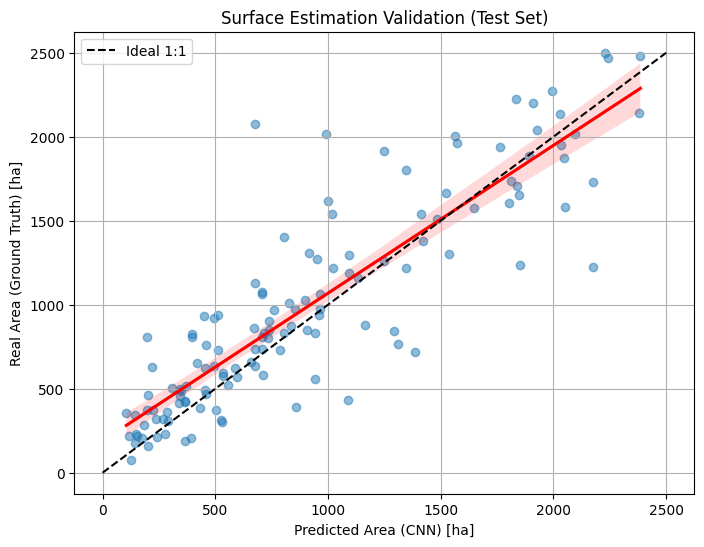

In [595]:
# get report
dfEvaluatorSentinel = evaluatorSentinel.get_metrics_report()

# Show table
print("\n=== REPORTE DE EFICIENCIA DEL MODELO SENTINEL ===")
print(dfEvaluatorSentinel.round(4).to_string(index=False))
# Plot regression
evaluatorSentinel.plot_regression()



=== REPORTE DE EFICIENCIA DEL MODELO PERUSAT ===
               Metric   Value                                   Interpretation
        IoU (Jaccard)  0.6689                          Quality of mask overlap
      F1-Score (Dice)  0.8016             Balance between precision and recall
 Precision (User Acc)  0.8197 How much of the predicted area is actually crop?
Recall (Producer Acc)  0.7843     How much of the real crop area was detected?
     Overall Accuracy  0.8199      Overall accuracy (influenced by background)
            RMSE (ha) 30.8408                  Average error in area per image
             Bias (%) -4.3198        Tendency to over/underestimate total area
     R2 (Correlation)  0.6304              Ability to replicate the real trend


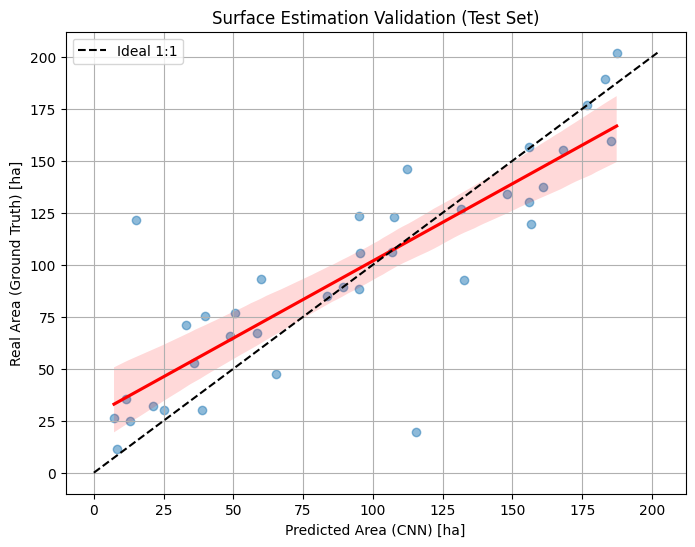

In [596]:
dfEvaluatorPeruSat = evaluatorPeruSat.get_metrics_report()
print("\n=== REPORTE DE EFICIENCIA DEL MODELO PERUSAT ===")
print(dfEvaluatorPeruSat.round(4).to_string(index=False))
# Plot regression
evaluatorPeruSat.plot_regression()

# Train and test - Dry Season

## Split

In [135]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [136]:
imageDry = sorted(glob.glob(imagesDrySeason + "/*.tif"))
maskDry = sorted(glob.glob(masksDrySeason + "/*.png"))
trainTilesDry, testTilesDry, trainDryMasks, testDryMasks = train_test_split(
    imageDry, maskDry, test_size=0.3, random_state=42
)

In [137]:
trainDryDS = FourBandSegmentationDataset(imagesDrySeason, masksDrySeason, files_list=(trainTilesDry, trainDryMasks))
testDryDS = FourBandSegmentationDataset(imagesDrySeason, masksDrySeason, files_list=(testTilesDry, testDryMasks))

In [138]:
batch_size = 4
trainloaderDry = DataLoader(trainDryDS, batch_size=batch_size, shuffle=True)
testloaderDry = DataLoader(testDryDS, batch_size=batch_size, shuffle=True)

In [139]:
len(trainDryDS),len(testDryDS)

(263, 114)

## Load of base model - dry

In [140]:
inputBands = 4
outputBands=1

In [141]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

In [142]:
class UNetDry(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [143]:
#Losses:

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss
    
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

In [144]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [145]:
print(torch.cuda.is_available())
device = torch.device(1 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:1


In [146]:
modelDry = UNetDry(in_channels=inputBands, out_channels=outputBands).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(modelDry.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 50

In [52]:
modelDry.load_state_dict(torch.load(BaseWeightDryPath, map_location=device))

<All keys matched successfully>

## Test pre-training

In [147]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics
    return {k: np.mean(v) for k, v in results.items()}

In [148]:
predict_th = 0.5

In [149]:
metrics_list = []

modelDry.eval()
with torch.no_grad():
    for img, mask in trainloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [150]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.0383
Dice: 0.0735
Precision: 0.4327
Recall: 0.0425


In [151]:
metrics_list = []

modelDry.eval()
with torch.no_grad():
    for img, mask in testloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [152]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.0370
Dice: 0.0712
Precision: 0.4574
Recall: 0.0408


## Training

In [153]:
modelDry.train()

UNetDry(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequenti

In [154]:
#Train loop:
def get_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def get_jaccard(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

def train_model(model, loss_function, optimizer, epochs, train_loader, test_loader, device,patience=5, save_path=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        #train_acc = 0.0
        train_jaccard = 0.0
        n_train = 0

        for imgs, masks in train_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            batch_size = imgs.size(0)
            train_loss += loss.item() * batch_size
            #train_acc += get_accuracy(outputs, masks) * batch_size
            train_jaccard += get_jaccard(outputs, masks) * batch_size
            n_train += batch_size

        train_loss /= n_train
        #train_acc /= n_train
        train_jaccard /= n_train
        train_losses.append(train_loss)
        #train_accuracies.append(train_acc.cpu().item())
        train_accuracies.append(train_jaccard.cpu().item())

        model.eval()
        test_loss = 0.0
        #test_acc = 0.0
        test_jaccard = 0.0
        n_test = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device).float()
                masks = masks.to(device).float()
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                batch_size = imgs.size(0)
                test_loss += loss.item() * batch_size
                #test_acc += get_accuracy(outputs, masks) * batch_size
                test_jaccard += get_jaccard(outputs, masks) * batch_size
                n_test += batch_size

        test_loss /= n_test
        #test_acc /= n_test
        test_jaccard /= n_test
        test_losses.append(test_loss)
        #test_accuracies.append(test_acc.cpu().item())
        test_accuracies.append(test_jaccard.cpu().item())

        #print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - jacc: {train_jaccard:.4f} - val_loss: {test_loss:.4f} - val_jacc: {test_jaccard:.4f}")

        if save_path is not None:
            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [245]:
modelDry.load_state_dict(torch.load(BaseWeightDryPath, map_location=device))

<All keys matched successfully>

In [246]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestModelDry = os.path.join(weightsDrySeason, f"weights_{timestamp}.pth")
os.makedirs(os.path.dirname(bestModelDry), exist_ok=True)


In [247]:
bestModelDry

'/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights/weights_20251129_191320.pth'

In [248]:
print(device)

cuda:1


In [250]:
# Entrenamiento
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.7, beta=0.3)
optimizer = optim.AdamW(modelDry.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 70
pat = 20

In [251]:
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    modelDry, criterion, optimizer, epochs, trainloaderDry, testloaderDry, device,patience = pat,save_path=bestModelDry
)

Epoch 1/70 - loss: 0.3889 - jacc: 0.4787 - val_loss: 0.3429 - val_jacc: 0.5566
Epoch 2/70 - loss: 0.3374 - jacc: 0.5339 - val_loss: 0.3356 - val_jacc: 0.5650
Epoch 3/70 - loss: 0.3263 - jacc: 0.5390 - val_loss: 0.3043 - val_jacc: 0.5417
Epoch 4/70 - loss: 0.3126 - jacc: 0.5553 - val_loss: 0.3013 - val_jacc: 0.5607
Epoch 5/70 - loss: 0.3120 - jacc: 0.5536 - val_loss: 0.2838 - val_jacc: 0.5539
Epoch 6/70 - loss: 0.3023 - jacc: 0.5478 - val_loss: 0.3102 - val_jacc: 0.5350
Epoch 7/70 - loss: 0.2917 - jacc: 0.5644 - val_loss: 0.2707 - val_jacc: 0.5966
Epoch 8/70 - loss: 0.2987 - jacc: 0.5606 - val_loss: 0.2949 - val_jacc: 0.5978
Epoch 9/70 - loss: 0.2848 - jacc: 0.5738 - val_loss: 0.2756 - val_jacc: 0.5838
Epoch 10/70 - loss: 0.2800 - jacc: 0.5776 - val_loss: 0.3694 - val_jacc: 0.5397
Epoch 11/70 - loss: 0.3168 - jacc: 0.5422 - val_loss: 0.3013 - val_jacc: 0.5668
Epoch 12/70 - loss: 0.2893 - jacc: 0.5733 - val_loss: 0.2969 - val_jacc: 0.5336
Epoch 13/70 - loss: 0.3097 - jacc: 0.5411 - val_l

In [252]:
def show_results(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label='train')
    ax1.plot(test_losses, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(test_accuracies, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

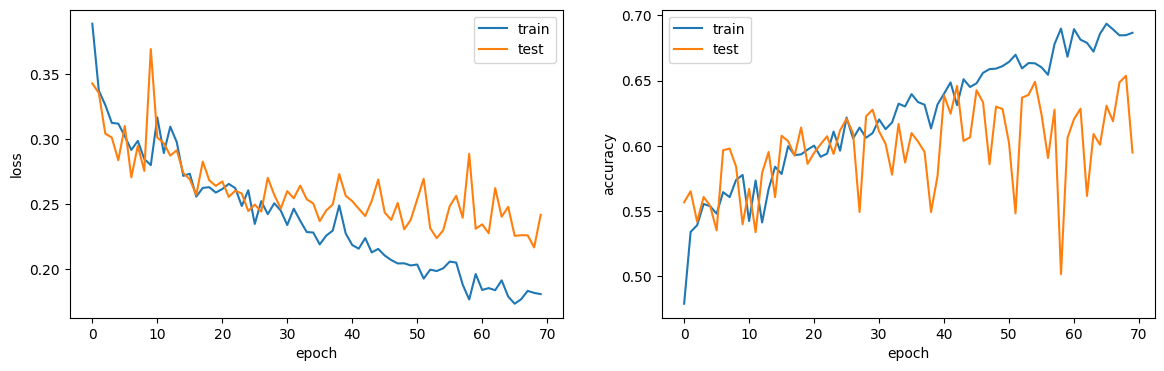

In [253]:
# Visualize
show_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
predict_th = 0.5

In [255]:
modelDry.load_state_dict(torch.load(bestModelDry, map_location=device))

<All keys matched successfully>

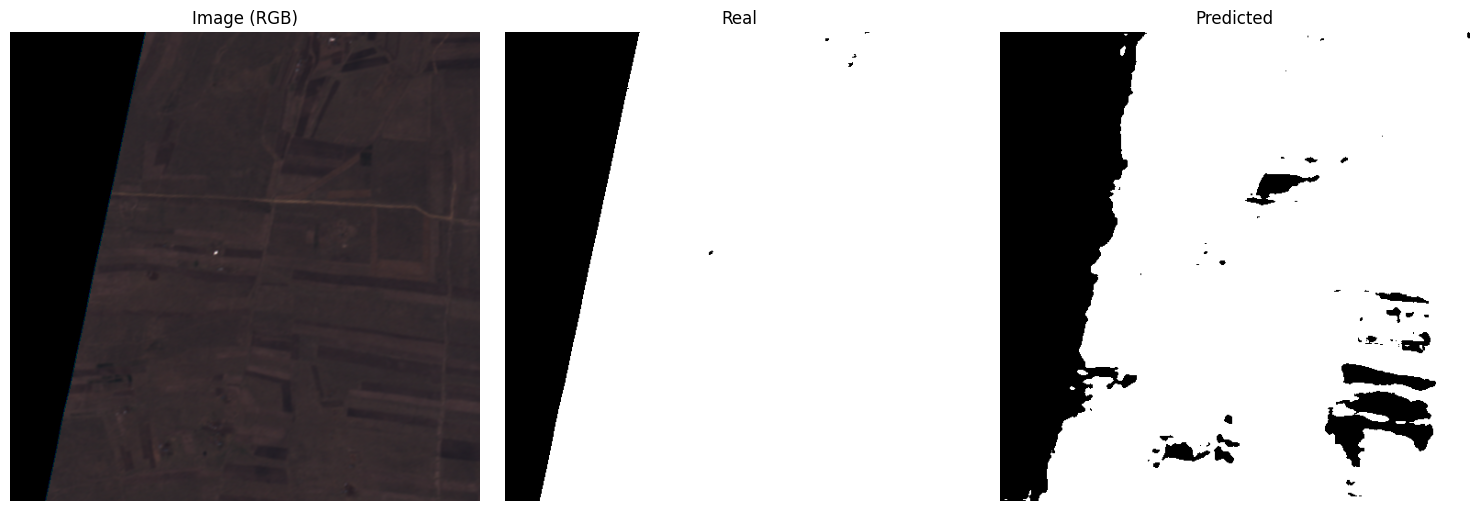

In [471]:
# Eval and visualize
modelDry.eval()
with torch.no_grad():
    imgs, masks = next(iter(testloaderDry))
    imgs = imgs.to(device)
    outputs = modelDry(imgs)
    pred_mask = (outputs[0] > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Metrics

In [ ]:
modelToEvalPath = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights/AndeanCropModelModifiedDry.pth"
modelDry.load_state_dict(torch.load(modelToEvalPath, map_location=device))

<All keys matched successfully>

In [19]:
device

device(type='cuda', index=1)

In [227]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics

In [407]:
predict_th = 0.5

In [408]:
metrics_list = []

modelDry.eval()
with torch.no_grad():
    for img, mask in trainloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [409]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.7107
Dice: 0.8260
Precision: 0.8609
Recall: 0.7982


In [410]:
modelDry.eval()
with torch.no_grad():
    for img, mask in testloaderDry:
        img, mask = img.to(device), mask.to(device)
        output = modelDry(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [411]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.6895
Dice: 0.8095
Precision: 0.8379
Recall: 0.7905


## Predictions

In [433]:
predictionsDrySeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Predictions'

In [434]:
# 1. CREATE THE SORTED LOADER
pred_loader = DataLoader(testDryDS, batch_size=4, shuffle=False)

# 2. FILENAME REFERENCE
files_list = testTilesDry 

modelDry.eval()
index = 0  # Global counter to track the filename list

with torch.no_grad():
    for imgs, masks in pred_loader:
        imgs = imgs.to(device)
        
        # Inference
        outputs = modelDry(imgs)
        preds = (outputs > predict_th).float().cpu().numpy()

        # Iterate within the batch (j goes from 0 to batch_size-1)
        for j in range(len(imgs)):
            
            # Safety check (prevents index out of range errors)
            if index >= len(files_list):
                break

            # A. GET THE ACTUAL FILENAME
            img_path = files_list[index]
            index += 1  # Prepare index for the next image

            # B. RENAME (Your original logic)
            filename = os.path.basename(img_path)
            
            if filename.endswith('_p_f.tif'):
                filename = filename.replace('_p_f.tif', '_predicted.png')
            elif filename.endswith('_p.tif'):
                filename = filename.replace('_p.tif', '_predicted.png')
            else:
                filename = filename.replace('.tif', '_predicted.png')

            out_path = os.path.join(predictionsDrySeason, filename)

            # C. SAVE
            pred_mask = (preds[j][0] * 255).astype(np.uint8)
            Image.fromarray(pred_mask).save(out_path)

In [435]:
masksDrySeason

'/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Masks'

In [436]:
output_csv = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/DrySeasonReport.csv"

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Nombre de archivo", "Area (original)", "Area (predicted)"])

    for pred_name in sorted(os.listdir(predictionsDrySeason)):
        if not pred_name.endswith("_predicted.png"):
            continue

        # Base name (no ext)
        base_name = pred_name.replace("_predicted.png", "")

        # Path
        pred_path = os.path.join(predictionsDrySeason, pred_name)
        mask_path = os.path.join(masksDrySeason, base_name + "_m.png")

        # Verify original mask exists
        if not os.path.exists(mask_path):
            print("No mask found for ", base_name)
            continue

        # Read imgs
        pred_img = np.array(Image.open(pred_path))
        mask_img = np.array(Image.open(mask_path))

        #count white pixels
        pred_pixels = np.sum(pred_img > 127)
        orig_pixels = np.sum(mask_img > 127)

        # Get area per pixel based on sat
        if base_name.startswith("PS"):
            pixel_area = 2.8 * 2.8  # m²
        elif base_name.startswith("S2"):
            pixel_area = 10 * 10  # m²
        else:
            pixel_area = 1.0  # por seguridad

        # calculate total agricultural area per tile
        area_pred = pred_pixels * pixel_area
        area_orig = orig_pixels * pixel_area

        # Output to csv
        if area_orig > 0:
            diff_pct = ((area_pred - area_orig) / area_orig) * 100
        else:
            diff_pct = 0

        writer.writerow([
            base_name,
            int(area_orig),
            int(area_pred),
            round(diff_pct, 2)
        ])

## Statistical metrics - Evaluator

In [437]:
class ModelEvaluator:
    def __init__(self, pixel_size_m2=100):
        
        self.pixel_size = pixel_size_m2
        
        # 1. Accumulators for the Global Confusion Matrix (Pixel-level)
        self.total_tp = 0
        self.total_fp = 0
        self.total_fn = 0
        self.total_tn = 0
        
        # 2. Lists to store the area of EACH image (Image-level)
        # This is used to calculate RMSE and regression
        self.areas_real_ha = []
        self.areas_pred_ha = []
        
    def process_image(self, mask_real, mask_pred):
        # Flatten for confusion matrix
        y_true = mask_real.flatten()
        y_pred = mask_pred.flatten()
        
        # Calculate confusion matrix for THIS image
        # labels=[0, 1] ensures the matrix is always 2x2
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        
        # Add to global accumulators
        self.total_tp += tp
        self.total_fp += fp
        self.total_fn += fn
        self.total_tn += tn
        
        # Calculate areas in hectares for THIS image and save them
        area_real = (tp + fn) * self.pixel_size / 10000 # (TP + FN) is all that was actually crop
        area_pred = (tp + fp) * self.pixel_size / 10000 # (TP + FP) is all that the network said was crop
        
        self.areas_real_ha.append(area_real)
        self.areas_pred_ha.append(area_pred)

    def get_metrics_report(self):
        # --- A. Geometric Segmentation Metrics ---
        # Avoid division by zero
        epsilon = 1e-7
        
        # IoU (Intersection over Union)
        iou = self.total_tp / (self.total_tp + self.total_fp + self.total_fn + epsilon)
        
        # F1-Score (Dice Coefficient)
        precision = self.total_tp / (self.total_tp + self.total_fp + epsilon)
        recall = self.total_tp / (self.total_tp + self.total_fn + epsilon) 
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        
        # Specificity (True Negative Rate)
        specificity = self.total_tn / (self.total_tn + self.total_fp + epsilon)
        
        # Overall Accuracy
        total_pixels = self.total_tp + self.total_fp + self.total_fn + self.total_tn
        accuracy = (self.total_tp + self.total_tn) / total_pixels
        
        # --- B. Statistical Area Metrics (Regression) ---
        y_real = np.array(self.areas_real_ha)
        y_pred = np.array(self.areas_pred_ha)
        
        # RMSE (Root Mean Squared Error in hectares)
        rmse = np.sqrt(mean_squared_error(y_real, y_pred))
        
        # Percent Bias (Pbias)
        # If positive: The model overestimates. Negative: Underestimates.
        pbias = 100 * np.sum(y_pred - y_real) / np.sum(y_real)
        
        # R2 Score
        r2 = r2_score(y_real, y_pred)
        
        # Create report DataFrame
        metrics = {
            "Metric": ["IoU (Jaccard)", "F1-Score (Dice)", "Precision (User Acc)", "Recall (Producer Acc)", 
                        "Overall Accuracy", "RMSE (ha)", "Bias (%)", "R2 (Correlation)"],
            "Value": [iou, f1, precision, recall, accuracy, rmse, pbias, r2],
            "Interpretation": [
                "Quality of mask overlap",
                "Balance between precision and recall",
                "How much of the predicted area is actually crop?",
                "How much of the real crop area was detected?",
                "Overall accuracy (influenced by background)",
                "Average error in area per image",
                "Tendency to over/underestimate total area",
                "Ability to replicate the real trend"
            ]
        }
        
        return pd.DataFrame(metrics)

    def plot_regression(self):
        plt.figure(figsize=(8, 6))
        sns.regplot(x=self.areas_pred_ha, y=self.areas_real_ha, ci=95, 
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.plot([0, max(self.areas_real_ha)], [0, max(self.areas_real_ha)], 'k--', label='Ideal 1:1')
        plt.xlabel('Predicted Area (CNN) [ha]')
        plt.ylabel('Real Area (Ground Truth) [ha]')
        plt.title('Surface Estimation Validation (Test Set)')
        plt.legend()
        plt.grid(True)
        plt.show()



In [438]:
pixelDefSentinel = 10
pixelDefPeruSat = 2.8
evaluatorSentinel = ModelEvaluator(pixel_size_m2=(pixelDefSentinel*pixelDefSentinel)) 
evaluatorPeruSat = ModelEvaluator(pixel_size_m2=(pixelDefPeruSat*pixelDefPeruSat))

In [ ]:
#Single loop to add images to evaluators Sentinel and PeruSat
#The masks predicted are in predictionsDrySeason folder
#While the real masks are in masksDrySeason folder

for pred_name in sorted(os.listdir(predictionsDrySeason)):
    if not pred_name.endswith("_predicted.png"):
        continue

    # Base name (no ext)
    base_name = pred_name.replace("_predicted.png", "")

    # Path
    pred_path = os.path.join(predictionsDrySeason, pred_name)
    mask_path = os.path.join(masksDrySeason, base_name + "_m.png")

    # Verify original mask exists
    if not os.path.exists(mask_path):
        print("No mask found for ", base_name)
        continue

    # Read imgs
    pred_img = np.array(Image.open(pred_path))
    mask_img = np.array(Image.open(mask_path))

    # Binarize
    pred_mask = (pred_img > 127).astype(np.uint8)
    real_mask = (mask_img > 127).astype(np.uint8)

    # Determine which evaluator to use based on satellite type
    if base_name.startswith("S2"):
        evaluatorSentinel.process_image(real_mask, pred_mask)
    elif base_name.startswith("PS"):
        evaluatorPeruSat.process_image(real_mask, pred_mask)
    else:
        print("Unknown satellite type for ", base_name)


=== REPORTE DE EFICIENCIA DEL MODELO SENTINEL ===
               Metric    Value                                   Interpretation
        IoU (Jaccard)   0.4438                          Quality of mask overlap
      F1-Score (Dice)   0.6147             Balance between precision and recall
 Precision (User Acc)   0.6913 How much of the predicted area is actually crop?
Recall (Producer Acc)   0.5534     How much of the real crop area was detected?
     Overall Accuracy   0.7863      Overall accuracy (influenced by background)
            RMSE (ha) 352.0447                  Average error in area per image
             Bias (%) -19.9499        Tendency to over/underestimate total area
     R2 (Correlation)   0.2456              Ability to replicate the real trend


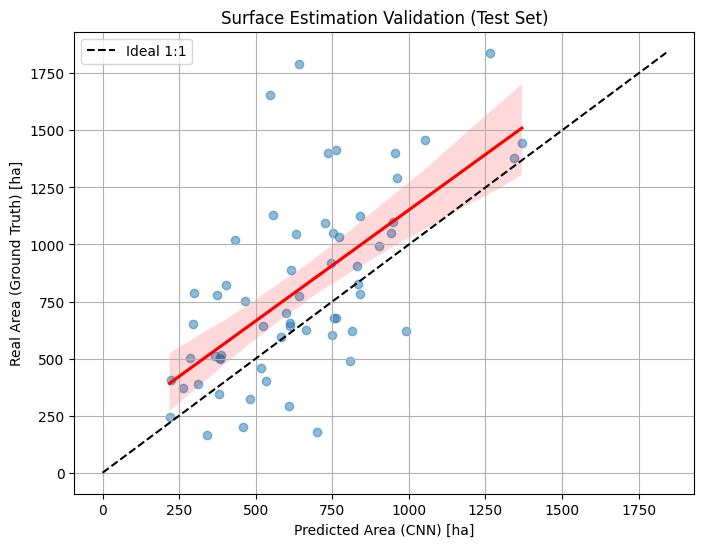

In [440]:
# get report
dfEvaluatorSentinel = evaluatorSentinel.get_metrics_report()

# Show table
print("\n=== REPORTE DE EFICIENCIA DEL MODELO SENTINEL ===")
print(dfEvaluatorSentinel.round(4).to_string(index=False))
# Plot regression
evaluatorSentinel.plot_regression()



=== REPORTE DE EFICIENCIA DEL MODELO PERUSAT ===
               Metric   Value                                   Interpretation
        IoU (Jaccard)  0.7917                          Quality of mask overlap
      F1-Score (Dice)  0.8837             Balance between precision and recall
 Precision (User Acc)  0.8467 How much of the predicted area is actually crop?
Recall (Producer Acc)  0.9242     How much of the real crop area was detected?
     Overall Accuracy  0.8284      Overall accuracy (influenced by background)
            RMSE (ha) 33.9177                  Average error in area per image
             Bias (%)  9.1506        Tendency to over/underestimate total area
     R2 (Correlation)  0.6159              Ability to replicate the real trend


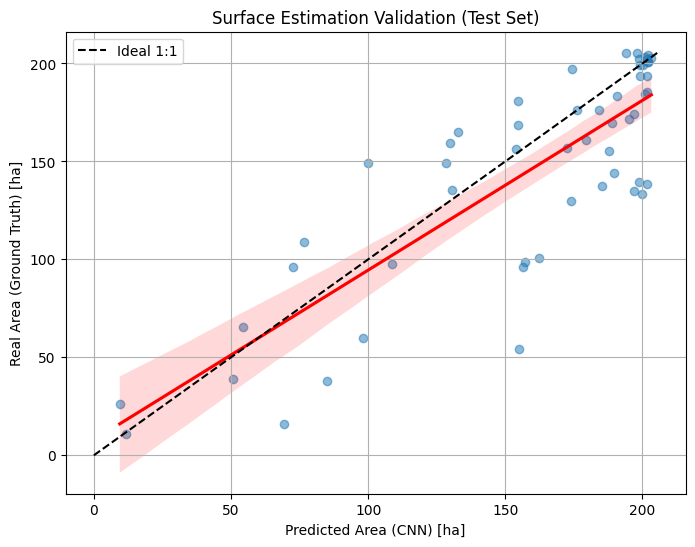

In [441]:
dfEvaluatorPeruSat = evaluatorPeruSat.get_metrics_report()
print("\n=== REPORTE DE EFICIENCIA DEL MODELO PERUSAT ===")
print(dfEvaluatorPeruSat.round(4).to_string(index=False))
# Plot regression
evaluatorPeruSat.plot_regression()